In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
def plot_9(imgs, labels=None, filename=None):
    imgs = [to_uint8(img) for img in imgs]
    if labels is None:
        labels = [None for i in range(len(imgs))]
    plt.figure(figsize=(10, 10))
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis("off")
    if filename is not None:
        plt.savefig(filename)
        plt.close()

def normalise(img):
    img = np.float32(img)
    img -= np.min(img)
    img /= np.max(img)
    img = img*2 - 1
    return img

def import_images_from_folder(folder_path, num=5000):
    imgs = []
    for relative_img_path in os.listdir(folder_path)[:num]:
        if relative_img_path.endswith('.jpg'):
            try:
              img = cv2.imread(folder_path + relative_img_path)
              imgs.append(img)
            except:
              print('error occured with: ', relative_img_path)
    print('Imported '+str(len(imgs))+' images.')
    return imgs

def to_uint8(img):
    return np.uint8((img + 1) * 127.5)

def render(imgs, filename):
    cv2.imwrite('./view/'+filename, np.concatenate(imgs, axis=1))

def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
# faces
!gdown 1vEES1-EL4Ct9Q_kEwXry3NKMQ2tsc-qC

# vegetables
!gdown 1pFcVXGpjKt8233h54gkUEyh1djTMWGpS

# cars
!gdown 1af0QJcTzhvPYKj1E2c-WQkhn4ehg8BLl

# ill leaves
!gdown 1wFp1UUntJRvR0uqjpSv5Zu5GoGVhC9DP

# flowers
!gdown 1BKNtOOiWSWwm3H1fDp1W72BXxIepRkAv

# playing cards
!gdown 1b8lCjPZtolXgkm8CLgL54NFFptz4vqXL

Downloading...
From: https://drive.google.com/uc?id=1vEES1-EL4Ct9Q_kEwXry3NKMQ2tsc-qC
To: /content/faces.zip
100% 163M/163M [00:00<00:00, 196MB/s]


In [4]:
!unzip faces.zip

Archive:  faces.zip
replace faces/10000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace faces/10001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!mkdir view

In [3]:
img_dir = "./faces/"
size = 64

In [4]:
# import dataset
images = import_images_from_folder(img_dir)

Imported 5000 images.


(250, 250, 3) 0 255


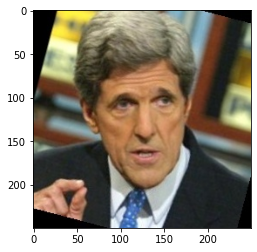

In [5]:
# show example image
img = cv2.imread(img_dir + os.listdir(img_dir)[100])
print(img.shape, img.min(), img.max())
show(img)

(64, 64, 3) -1.0 1.0


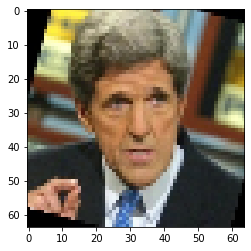

In [6]:
# show padded images
def norm_and_resize_with_padding(img, size):
    size_max = np.max(img.shape)
    r = size/size_max
    img = cv2.resize(img, (int(round(img.shape[1]*r)), int(round(img.shape[0]*r))))
    img = normalise(img)
    offset_height = (size - img.shape[0])//2
    offset_width = (size - img.shape[1])//2
    canvas = np.float32(-np.ones((size,size,3)))
    canvas[offset_height : offset_height + img.shape[0], offset_width : offset_width + img.shape[1]] = img
    return canvas

img = cv2.imread(img_dir + os.listdir(img_dir)[100])
img = norm_and_resize_with_padding(img, size)
print(img.shape, img.min(), img.max())
img = to_uint8(img)
show(img)

In [7]:
# preprocess whole dataset
images = [norm_and_resize_with_padding(img, size=64) for img in images]

In [8]:
# plot 9 preprocessed imgs
plot_9(images[:9])

In [9]:
# build torch tensor
images = np.float32(images)
images = np.transpose(images, (0, 3, 1, 2))
images = torch.Tensor(images)

In [10]:
# test pytorch module
class DummyModel(nn.Module):
    def __init__(
        self,
        n_channels_in,
        n_channels_out
        ):
        super(DummyModel, self).__init__()

        self.path = nn.Sequential(
            nn.Conv2d(n_channels_in, n_channels_out, 1),
            nn.ReLU(True))

    def forward(self, x):
        return self.path(x)

In [11]:
# Test the DummyModel
testmodel = DummyModel(3, 16)
x = images[:4]
y = testmodel(x)
print(y.shape)

torch.Size([4, 16, 64, 64])


In [12]:
# Generator Model
class Generator(nn.Module):
    def __init__(
        self,
        n_latent_dimensions,
        channel_multiplier
        ):
        # inherit
        super(Generator, self).__init__()
        # write additional args
        self.n_latent_dimensions = n_latent_dimensions

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(
                in_channels = n_latent_dimensions,
                out_channels = channel_multiplier*8, 
                kernel_size = 4,
                bias=False),
            nn.BatchNorm2d(channel_multiplier*8),
            nn.ReLU(True),
            # ngf*8 x 4 x 4
            nn.ConvTranspose2d(channel_multiplier*8, channel_multiplier*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*4),
            nn.ReLU(True),
            # ngf*4 x 8 x 8
            nn.ConvTranspose2d(channel_multiplier* 4, channel_multiplier* 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*2),
            nn.ReLU(True),
            # ngf*2 x 16 x 16
            nn.ConvTranspose2d(channel_multiplier*2, channel_multiplier, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier),
            nn.ReLU(True),
            # ngf x 32 x 32
            nn.ConvTranspose2d(channel_multiplier, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # nc x 64 x 64
        )

    def forward(self, input):
        x = torch.unsqueeze(torch.unsqueeze(input, -1), -1)
        return self.main(x)

In [13]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(
        self,
        channel_multiplier
        ):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, channel_multiplier, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(channel_multiplier, channel_multiplier*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(channel_multiplier*2, channel_multiplier*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(channel_multiplier*4, channel_multiplier*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(channel_multiplier*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
# Initialisierung
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Models definieren
n_latent_dimensions = 100
channel_multiplier=64

G = Generator(
    n_latent_dimensions=n_latent_dimensions,
    channel_multiplier=channel_multiplier
    )

D = Discriminator(
    channel_multiplier=channel_multiplier//4
    )

In [15]:
G

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [16]:
D

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [17]:
# Schnappen wir uns unsere GPU bzw. CPU wenn keine GPU vorhanden ist.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Nun kopieren wir unsere Models auf das device mit der Methode .to
D = D.to(device)
G = G.to(device)

In [18]:
# Den Optimizern in PyTorch übergeben wir die Methode 'parameters' des zu optimierenden Models und die learning rate.
opt_discriminator = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_generator = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [19]:
# PyTorch Dataset Objekt
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, steps_per_epoch, n_latent_dimensions, images):
        'Initialization'
        self.images = images
        self.steps_per_epoch = steps_per_epoch
        self.n_latent_dimensions = n_latent_dimensions

    def __len__(self):
        'Denotes the total number of samples'
        return self.steps_per_epoch

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select image uniformly
        idx = np.random.choice(len(self.images))
        x = self.images[idx]
        # sample latent code
        z = torch.randn(self.n_latent_dimensions)
        return x, z

In [20]:
# Test Dataset
batch_size = 64
UniformSampler = MyDataset(batch_size*100, n_latent_dimensions, images)

In [21]:
train_loader = DataLoader(
    UniformSampler,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)

In [22]:
# TRAINING

@torch.no_grad()
def plot_9_generated_imgs(filename=None):
    z = torch.randn((9, n_latent_dimensions)).to(device)
    imgs = G(z).cpu().detach().numpy()
    imgs = np.transpose(imgs, (0, 2, 3, 1)) 
    plot_9([img for img in imgs], labels=None, filename=filename)

def binary_crossentropy(pred, label):
    loss = -(label * torch.log(pred+1e-7) + (1-label) * torch.log(1-pred+1e-7))
    loss = torch.mean(loss)
    return loss

def get_gradients(wrt, target):
    gradients = torch.autograd.grad(
        inputs = wrt,
        outputs = target,
        grad_outputs=torch.ones_like(target),
        allow_unused=True,
        create_graph=True,
        retain_graph=True)
    return gradients

def apply_gradients(model, gradients):
    for g, p in zip(gradients, model.parameters()):
        if g is not None:
            g = g.detach().clone()
            p.grad = g
    return model

def format_loss(x):
    x = str(np.round(x.cpu().detach().numpy(), 4))
    while len(x) < 8:
        x += '0'
    if len(x) >= 8:
        x = x[:8]
    return x

def train_step(real, z, G, D, opt_generator, opt_discriminator):
    opt_generator.zero_grad()
    opt_discriminator.zero_grad()

    real = real.to(device)
    z = z.to(device)

    fake = G(z)

    d_fake = D(fake)
    d_real = D(real)

    d_loss = binary_crossentropy(d_fake, 0) + binary_crossentropy(d_real, 1)
    g_loss = binary_crossentropy(d_fake, 1)

    grads_d = get_gradients(D.parameters(), d_loss)
    grads_g = get_gradients(G.parameters(), g_loss)
    D = apply_gradients(D, grads_d)
    G = apply_gradients(G, grads_g)
    opt_discriminator.step()
    opt_generator.step()

    d_loss = format_loss(d_loss)
    g_loss = format_loss(g_loss)
    return d_loss, g_loss

In [23]:
plot_9_generated_imgs()

In [ ]:
for epoch in range(0, 200):
    plot_9_generated_imgs(filename='./view/'+str(epoch)+'.jpg')
    pbar = tqdm(train_loader)
    for batch in pbar:
        real, z = batch
        x = train_step(real, z, G, D, opt_generator, opt_discriminator)
        pbar.set_description(str(x))

In [25]:
# make a video of the progression

image_folder = '/content/view/'
video_name = 'progression.mp4'

video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc('M','J','P','G'), 2, (720,720))

for i in range(len(os.listdir(image_folder))):
    filename = os.path.join(image_folder, str(i)+'.jpg')
    video.write(cv2.imread(filename))

cv2.destroyAllWindows()
video.release()